## ATAC + MULTIOME (gonadal somatic) - september 2021

### Build anndata from cellatac output 

In [99]:
# Load libraries
import pandas as pd 
import scanpy as sc
import numpy as np
import scipy.sparse

In [100]:
# Define variables
outdir = "/nfs/team292/vl6/my_MULTIOME_dir/supporting_july2021/"
experiment_prefix = 'supporting_'
cellatac_outdir = '/lustre/scratch117/cellgen/cellgeni/TIC-atacseq/tic-1138/support-results200k/'


In [101]:
input={'cnts': cellatac_outdir + 'peak_matrix/peaks_bc_matrix.mmtx.gz',
        "bcs": cellatac_outdir + 'peak_matrix/bc.txt',
      "peaks": cellatac_outdir + 'peak_matrix/peaks.txt',
      'clusters': cellatac_outdir + 'qc/seurat-clades.tsv'}

output = {
    "cnt_mmtx":outdir + experiment_prefix + '_ATAC_cisTopic.mmtx',
    "cnt_peaks":outdir + experiment_prefix + '_ATAC_cisTopic.peaks.tsv',
    "cnt_cells":outdir + experiment_prefix + '_ATAC_cisTopic.cells.tsv',
    "h5ad":outdir + experiment_prefix + '_ATAC_raw.h5ad',
}

#### Make anndata object

In [102]:
adata = sc.read_mtx(input["cnts"]).T

bc = pd.read_table(input["bcs"], header=None)
feat = pd.read_table(input["peaks"], header=None)

adata.obs_names = bc[0]
adata.var_names = feat[0]

In [103]:
adata

AnnData object with n_obs × n_vars = 78750 × 391697

In [104]:
# Code from cell barcodes 
adata.obs['code'] = [name[0:2] for name in adata.obs_names]
adata.obs['code'].value_counts(dropna = False)

16    9102
06    7769
22    5332
19    4564
18    4470
21    4354
13    4072
20    3825
27    3687
26    3548
23    3515
15    2866
11    2654
17    2586
14    2224
05    1782
28    1631
01    1323
02    1287
25    1164
10    1140
24    1126
08    1115
04     978
29     900
07     637
03     562
09     375
12     162
Name: code, dtype: int64

In [105]:
# Sample from code 
sample_code = {'01' : 'FCA_GND10288176', '02' : 'FCA_GND10288177', '03' : 'FCA_GND10288178', '04' : 'FCA_GND10288179', 
               '05' : 'FCA_GND10288180', '06' : 'FCA_GND8046539', '07' : 'FCA_GND8768481', '08' : 'FCA_GND8768482',
               '09' : 'FCA_GND8768483', '10' : 'FCA_GND8768484', '11' : 'FCA_GND8768485', '12' : 'FCA_GND8768487',
               '13' : 'FCA_GND8795927', '14' : 'FCA_GND8795928', '15' : 'FCA_GND9332157', '16' : 'HCA_F_GON10535399',
               '17' : 'HCA_F_GON10687818', '18' : 'HCA_F_GON10687819', '19' : 'HCA_F_GON10687820', '20' : 'HD_F_GON9479872',
               '21' : 'HD_F_GON9479873', '22' : 'HD_F_GON9479874', '23' : 'HD_F_GON9479875', '24' : 'HD_F_GON9525611',
               '25' : 'HD_F_GON9525612', '26' : 'HD_F_GON9883955', '27' : 'HD_F_GON9883958', '28' : 'HD_F_GON9883959',
               '29' : 'HD_F_GON9883960'}
adata.obs['sample'] = adata.obs['code'].map(sample_code) 
adata.obs['sample'].value_counts(dropna = False)

HCA_F_GON10535399    9102
FCA_GND8046539       7769
HD_F_GON9479874      5332
HCA_F_GON10687820    4564
HCA_F_GON10687819    4470
HD_F_GON9479873      4354
FCA_GND8795927       4072
HD_F_GON9479872      3825
HD_F_GON9883958      3687
HD_F_GON9883955      3548
HD_F_GON9479875      3515
FCA_GND9332157       2866
FCA_GND8768485       2654
HCA_F_GON10687818    2586
FCA_GND8795928       2224
FCA_GND10288180      1782
HD_F_GON9883959      1631
FCA_GND10288176      1323
FCA_GND10288177      1287
HD_F_GON9525612      1164
FCA_GND8768484       1140
HD_F_GON9525611      1126
FCA_GND8768482       1115
FCA_GND10288179       978
HD_F_GON9883960       900
FCA_GND8768481        637
FCA_GND10288178       562
FCA_GND8768483        375
FCA_GND8768487        162
Name: sample, dtype: int64

In [106]:
adata.obs.tail()

,code,sample
29-TTTGGTTAGTTGCTTG-1,29,HD_F_GON9883960
29-TTTGGTTCAAGATGCG-1,29,HD_F_GON9883960
29-TTTGGTTGTGTAGGAC-1,29,HD_F_GON9883960
29-TTTGTGTGTGCTGAAG-1,29,HD_F_GON9883960
29-TTTGTGTGTTAACCGT-1,29,HD_F_GON9883960


#### Load peak annotations (done with R script by Emma)

In [107]:
peak_anno_df = pd.read_csv(outdir + "ATACpeaks_annotation.csv", index_col=0)
peak_anno_df.index = peak_anno_df["peak_id"]
peak_anno_df.drop("peak_id",1, inplace=True)
adata.var = pd.concat([adata.var, peak_anno_df], 1)

#### Save binary data to layers

In [108]:
adata.layers["binary_raw"] = adata.X
adata.layers["binary_raw"][adata.layers["binary_raw"] > 1] = 1
adata

AnnData object with n_obs × n_vars = 78750 × 391697
    obs: 'code', 'sample'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist'
    layers: 'binary_raw'

#### Load annotations of snRNAseq from MULTIOME samples 

In [109]:
path_to_multiome = '/nfs/team292/lg18/with_valentina/gonadsV2_revision/'

In [110]:
code_correspondence = {'FCA_GND10288176' : '01', 'FCA_GND10288177' : '02', 'FCA_GND10288178' : '03',
       'FCA_GND10288179' : '04', 'FCA_GND10288180' : '05', 'HCA_F_GON10535399' : '16',
       'HCA_F_GON10687818' : '17', 'HCA_F_GON10687819' : '18', 'HCA_F_GON10687820' : '19',
       'HD_F_GON9525611' : '24', 'HD_F_GON9525612' : '25'}

In [111]:
supporting_female = pd.read_csv(path_to_multiome + 'multiomics_female_somatic.csv')
supporting_female.head()

,Unnamed: 0,n_genes,sample,donor,Library_ATAC,Library_RNA,iRods_path,percent_mito,n_counts,batch,...,pcw,lineage,celltype_previous,celltype_samplespecific,S_score,G2M_score,phase,leiden,leiden_R,celltype
0,HCA_F_GON10535495_AAACAGCCATAAGCAA,4286,HCA_F_GON10535495,Hrv92,HCA_F_GON10535399,HCA_F_GON10535495,/seq/illumina/cellranger-arc/cellranger-arc101...,0.024780,9347.0,0,...,8.6,Supporting,preGC_I,NaN,-0.279762,-0.437812,G1,3,3,preGC_I
1,HCA_F_GON10535495_AAACATGCACTAAGAA,3509,HCA_F_GON10535495,Hrv92,HCA_F_GON10535399,HCA_F_GON10535495,/seq/illumina/cellranger-arc/cellranger-arc101...,0.027097,6939.0,0,...,8.6,Supporting,preGC_I,NaN,-0.119048,-0.282884,G1,3,3,preGC_I
2,HCA_F_GON10535495_AAACCAACACTGACCG,4443,HCA_F_GON10535495,Hrv92,HCA_F_GON10535399,HCA_F_GON10535495,/seq/illumina/cellranger-arc/cellranger-arc101...,0.020062,9803.0,0,...,8.6,Supporting,preGC_I,NaN,-0.371032,-0.396936,G1,3,3,preGC_I
3,HCA_F_GON10535495_AAACCAACAGTAATAG,3430,HCA_F_GON10535495,Hrv92,HCA_F_GON10535399,HCA_F_GON10535495,/seq/illumina/cellranger-arc/cellranger-arc101...,0.018368,6758.0,0,...,8.6,Supporting,Mesenchymal_LHX9,NaN,-0.257937,-0.255245,G1,7,7,Mesenchymal_LHX9
4,HCA_F_GON10535495_AAACCGAAGAACAAGT,3627,HCA_F_GON10535495,Hrv92,HCA_F_GON10535399,HCA_F_GON10535495,/seq/illumina/cellranger-arc/cellranger-arc101...,0.026207,7202.0,0,...,8.6,Supporting,lowQC,NaN,-0.384921,-0.264652,G1,9,9,lowQC


In [112]:
supporting_male = pd.read_csv(path_to_multiome + 'multiomics_male_somatic.csv')
supporting_male.head()

,Unnamed: 0,n_genes,sample,donor,Library_ATAC,Library_RNA,iRods_path,percent_mito,n_counts,batch,...,bonf_pval,pcw,lineage,celltype_samplespecific,S_score,G2M_score,phase,leiden,leiden_R,celltype
0,HCA_F_GON10713286_AAACATGCAGGTATTT,3875,HCA_F_GON10713286,Hrv41,HCA_F_GON10687820,HCA_F_GON10713286,/seq/illumina/cellranger-arc/cellranger-arc101...,0.002676,10070.0,0,...,1.000000,8.8,Mesenchymal_LHX9,NaN,1.507850,0.092105,S,7,7,Mesenchymal_LHX9
1,HCA_F_GON10713286_AAACATGCAGTTTACG,5139,HCA_F_GON10713286,Hrv41,HCA_F_GON10687820,HCA_F_GON10713286,/seq/illumina/cellranger-arc/cellranger-arc101...,0.005092,13619.0,0,...,1.000000,8.8,Sertoli,NaN,-0.091674,-0.706570,G1,4,4,Sertoli
2,HCA_F_GON10713286_AAACCAACAAGCTTAT,5234,HCA_F_GON10713286,Hrv41,HCA_F_GON10687820,HCA_F_GON10713286,/seq/illumina/cellranger-arc/cellranger-arc101...,0.007096,14606.0,0,...,1.000000,8.8,Sertoli,NaN,-0.039820,-0.939547,G1,0,0,Sertoli
3,HCA_F_GON10713286_AAACCAACATAACGGG,1195,HCA_F_GON10713286,Hrv41,HCA_F_GON10687820,HCA_F_GON10713286,/seq/illumina/cellranger-arc/cellranger-arc101...,0.007257,1487.0,0,...,1.000000,8.8,Sertoli,NaN,-0.002272,-0.006809,G1,0,0,Sertoli
4,HCA_F_GON10713286_AAACCGAAGAAGCTAG,4897,HCA_F_GON10713286,Hrv41,HCA_F_GON10687820,HCA_F_GON10713286,/seq/illumina/cellranger-arc/cellranger-arc101...,0.004505,11114.0,0,...,0.046413,8.8,Sertoli,NaN,0.127001,-0.411759,S,0,0,Sertoli


In [113]:
supporting = supporting_female.append(supporting_male)
supporting['celltype'].value_counts(dropna = False)

Sertoli             6304
preGC_IIa           3470
preGC_I             3269
Mesenchymal_LHX9    3244
preGC_IIb           2165
early_sPAX8         1772
granulosa           1351
OSE                 1320
FetalLeydig         1235
early_supporting    1100
Doublet              943
CoelEpi_LHX9         653
OSE_cycling          641
lowQC                385
Name: celltype, dtype: int64

In [114]:
supporting['Library_ATAC'].value_counts(dropna = False)

HCA_F_GON10535399    7315
HCA_F_GON10687819    4824
HCA_F_GON10687820    4197
HCA_F_GON10687818    2614
FCA_GND10288180      1972
FCA_GND10288176      1693
FCA_GND10288177      1621
HD_F_GON9525612      1057
HD_F_GON9525611      1035
FCA_GND10288179       991
FCA_GND10288178       533
Name: Library_ATAC, dtype: int64

In [115]:
np.unique(supporting['Library_ATAC'])

array(['FCA_GND10288176', 'FCA_GND10288177', 'FCA_GND10288178',
       'FCA_GND10288179', 'FCA_GND10288180', 'HCA_F_GON10535399',
       'HCA_F_GON10687818', 'HCA_F_GON10687819', 'HCA_F_GON10687820',
       'HD_F_GON9525611', 'HD_F_GON9525612'], dtype=object)

In [116]:
supporting['ATAC_code'] = supporting['Library_ATAC'].map(code_correspondence)

In [117]:
supporting['barcode'] = [i.split('_')[-1] for i in supporting['Unnamed: 0']]

In [118]:
supporting['ATAC_barcode'] = supporting['ATAC_code'] + '-' + supporting['barcode'] + '-1'

In [119]:
adata.obs['multiome_Somatic'] = adata.obs_names.map(pd.Series(supporting.celltype.values,index=supporting.ATAC_barcode).to_dict())

In [120]:
adata.obs['multiome_Somatic'].value_counts(dropna = False)

NaN                 55589
Sertoli              5726
preGC_I              3062
preGC_IIa            2875
Mesenchymal_LHX9     2604
preGC_IIb            1747
early_sPAX8          1644
OSE                  1197
FetalLeydig          1115
early_supporting     1050
granulosa            1029
OSE_cycling           593
CoelEpi_LHX9          519
Name: multiome_Somatic, dtype: int64

#### Peak filtering

array([[<AxesSubplot:title={'center':'peak_width'}>]], dtype=object)

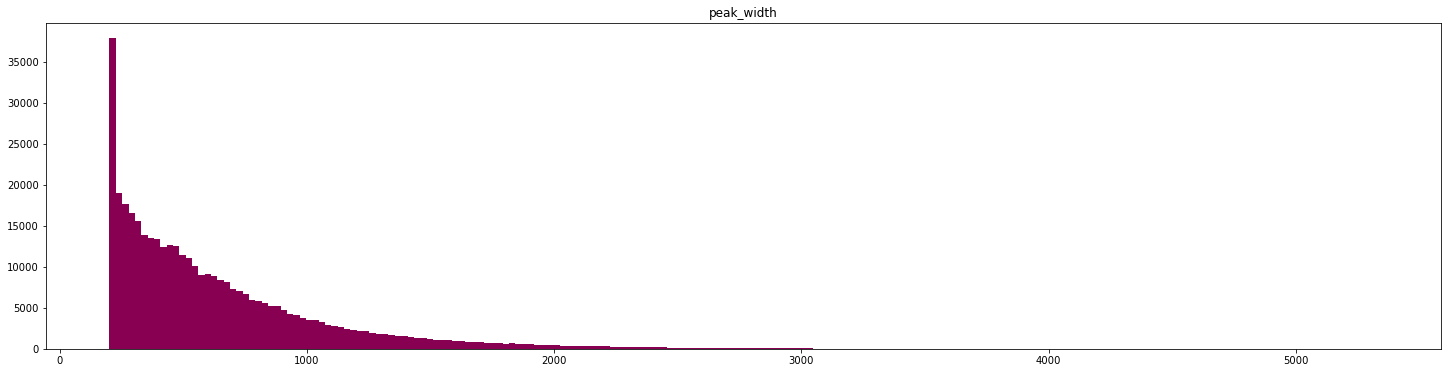

In [121]:
adata.var.hist(column = 'peak_width', bins = 200, grid = False, figsize = (25,6), color = '#870052')

In [122]:
var_qc = sc.pp.calculate_qc_metrics(adata, layer = "binary_raw")[1]
adata.var = pd.concat([adata.var, var_qc], 1)
adata

AnnData object with n_obs × n_vars = 78750 × 391697
    obs: 'code', 'sample', 'multiome_Somatic'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [123]:
adata.var.head()

,peak_width,exon,gene,promoter,annotation,gene_name,gene_id,tss_distance,ENCODE_blacklist,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
chr1:10003-10391,389,0,0,0,intergenic,NaN,NaN,58699,1,472,0.005994,0.005976,99.400635,472.0,6.159095
chr1:180676-181615,940,0,0,1,promoter,FO538757.2,ENSG00000279928,777,1,1873,0.023784,0.023506,97.621587,1873.0,7.535830
chr1:191340-191559,220,0,1,0,intron,FO538757.1,ENSG00000279457,3851,1,205,0.002603,0.002600,99.739683,205.0,5.327876
chr1:267865-268095,231,0,0,0,intergenic,NaN,NaN,67542,1,793,0.010070,0.010019,98.993016,793.0,6.677083
chr1:586070-586287,218,0,0,0,intergenic,NaN,NaN,100366,1,675,0.008571,0.008535,99.142857,675.0,6.516193


array([[<AxesSubplot:title={'center':'total_counts'}>]], dtype=object)

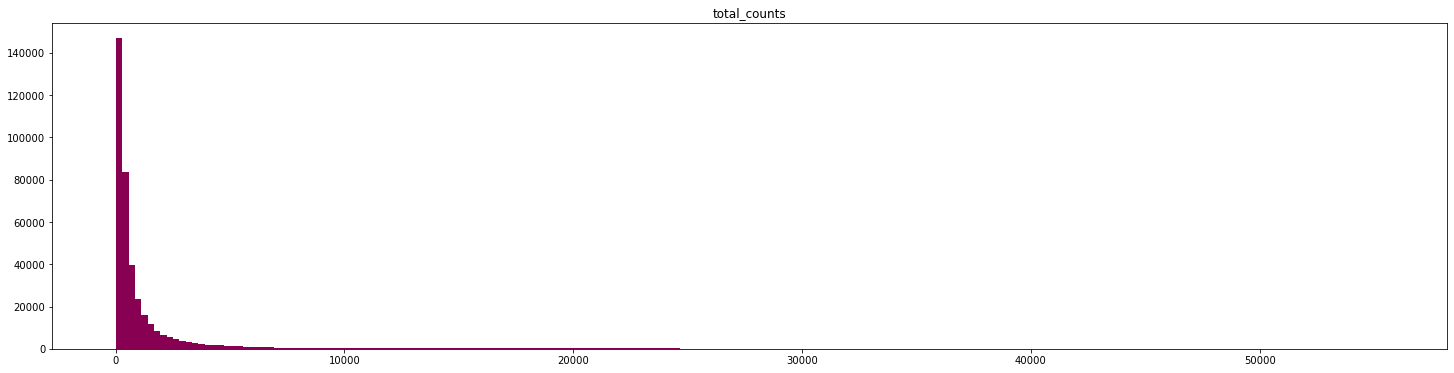

In [124]:
adata.var.hist(column = 'total_counts', bins = 200, grid = False, figsize = (25,6), color = '#870052')

In [125]:
thirty_percent = len(adata.obs_names) / 100 * 30
point_one_percent = len(adata.obs_names) / 100 * 0.1
print("30% : {}".format(thirty_percent))
print("0.1% : {}".format(point_one_percent))

30% : 23625.0
0.1% : 78.75


In [126]:
# Accessible in at least k cells
adata = adata[:,adata.var.total_counts > point_one_percent]
adata = adata[:,adata.var.total_counts < thirty_percent]
adata

View of AnnData object with n_obs × n_vars = 78750 × 379839
    obs: 'code', 'sample', 'multiome_Somatic'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [127]:
# Remove peaks in ENCODE blacklist
adata = adata[:, adata.var.ENCODE_blacklist == 0]
adata

View of AnnData object with n_obs × n_vars = 78750 × 378314
    obs: 'code', 'sample', 'multiome_Somatic'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [128]:
# Filter by width (remove peaks at the lowest end, closest to min peak width in MACS2)

adata = adata[:, adata.var.peak_width > 210]
adata = adata[:, adata.var.peak_width < 1500]
adata

View of AnnData object with n_obs × n_vars = 78750 × 338064
    obs: 'code', 'sample', 'multiome_Somatic'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [129]:
adata.var.head()

,peak_width,exon,gene,promoter,annotation,gene_name,gene_id,tss_distance,ENCODE_blacklist,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
chr1:816748-817444,697,0,0,0,intergenic,NaN,NaN,106483,0,765,0.009714,0.009667,99.028571,765.0,6.641182
chr1:817870-818350,481,0,0,0,intergenic,NaN,NaN,105577,0,249,0.003162,0.003157,99.683810,249.0,5.521461
chr1:825667-826059,393,0,0,0,intergenic,NaN,NaN,97868,0,812,0.010311,0.010258,98.968889,812.0,6.700731
chr1:826598-827811,1214,0,0,0,intergenic,NaN,NaN,96116,0,10094,0.128178,0.120604,87.182222,10094.0,9.219795
chr1:828783-829046,264,0,0,0,intergenic,NaN,NaN,94881,0,362,0.004597,0.004586,99.540317,362.0,5.894403


In [130]:
adata.var['annotation'].value_counts()

intergenic    154184
intron        138401
exon           35355
promoter       10124
Name: annotation, dtype: int64

In [131]:
adata.obs.head()

,code,sample,multiome_Somatic
01-AAACAGCCACTAGCGT-1,01,FCA_GND10288176,preGC_IIb
01-AAACATGCATCCCGCT-1,01,FCA_GND10288176,preGC_IIb
01-AAACCGAAGTTATGGC-1,01,FCA_GND10288176,preGC_IIa
01-AAACCGCGTTTCGCCA-1,01,FCA_GND10288176,granulosa
01-AAACCGGCAACCCTCC-1,01,FCA_GND10288176,granulosa


In [132]:
### Filter peaks that are not accessible in at least 5% of cells from a coarse cluster
min_frac=0.04
# Load cluster information from cellatac outputs
clusters = pd.read_table(input["clusters"], header = None, index_col = 0)
clusters.columns = ["cellatac_clusters"]
adata.obs = clusters.loc[adata.obs_names]
adata

AnnData object with n_obs × n_vars = 78750 × 338064
    obs: 'cellatac_clusters'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [133]:
adata.obs.head()

,cellatac_clusters
01-AAACAGCCACTAGCGT-1,9
01-AAACATGCATCCCGCT-1,9
01-AAACCGAAGTTATGGC-1,9
01-AAACCGCGTTTCGCCA-1,9
01-AAACCGGCAACCCTCC-1,9


In [134]:
n_clusters = len(np.unique(adata.obs[["cellatac_clusters"]]))
clus_mat = np.empty([adata.n_obs, n_clusters])
for cl in np.unique(adata.obs[["cellatac_clusters"]]):
    clus_mat[np.where(adata.obs['cellatac_clusters']==cl)[0],cl] = 1

clus_mat = scipy.sparse.csr_matrix(clus_mat)
clus_mat[clus_mat != 1 ] = 0

/opt/conda/envs/atac_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3427: SparseEfficiencyWarning: Comparing a sparse matrix with a nonzero scalar using != is inefficient, try using == instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/envs/atac_env/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [135]:
cl_peak_mat = np.dot(clus_mat.T, adata.layers["binary_raw"])

In [136]:
cl_peak_frac = cl_peak_mat/clus_mat.sum(0).T

In [137]:
cl_peak_frac.max(0).shape

(1, 338064)

In [138]:
bool_matrix = cl_peak_frac.max(0) > min_frac
bool_matrix.shape

(1, 338064)

In [139]:
bool_vector = np.squeeze(np.asarray(bool_matrix))
bool_vector.shape

(338064,)

In [140]:
adata = adata[:, bool_vector]

In [141]:
adata

View of AnnData object with n_obs × n_vars = 78750 × 159132
    obs: 'cellatac_clusters'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [142]:
sc.pp.calculate_qc_metrics(adata, layer = "binary_raw", inplace = True)

Trying to set attribute `.obs` of view, copying.


array([[<AxesSubplot:title={'center':'log1p_total_counts'}>]],
      dtype=object)

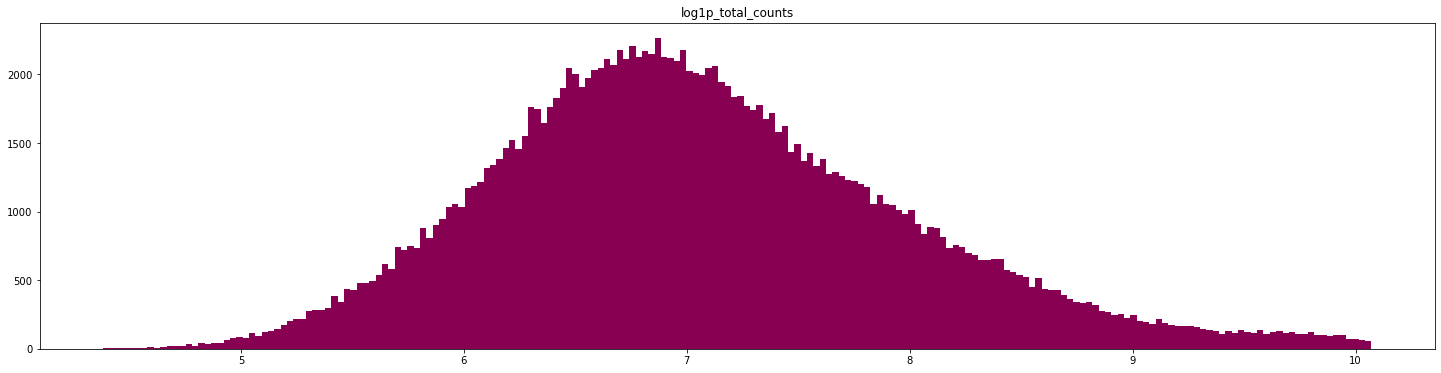

In [143]:
adata.var.hist(column = 'log1p_total_counts', bins = 200, grid = False, figsize = (25,6), color = '#870052')

array([[<AxesSubplot:title={'center':'log1p_total_counts'}>]],
      dtype=object)

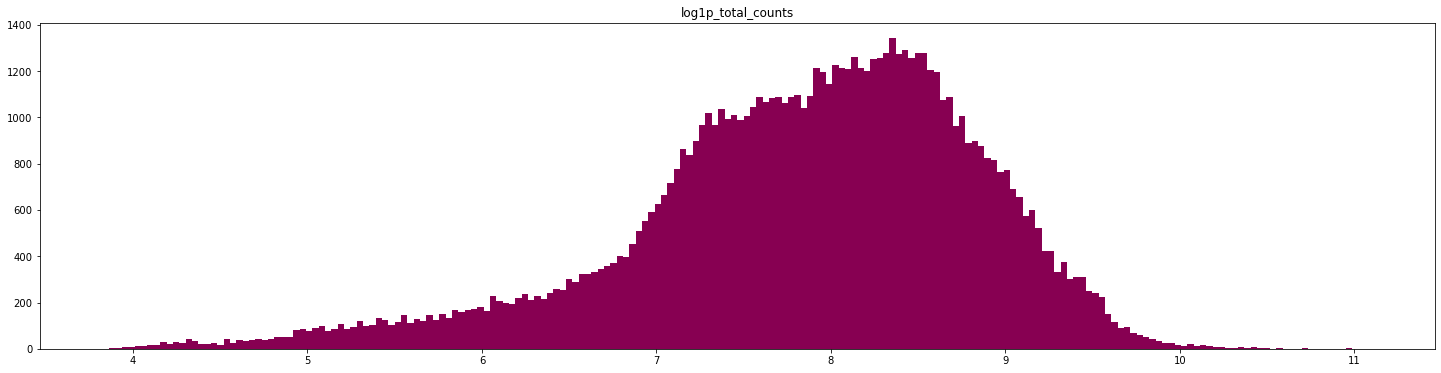

In [144]:
adata.obs.hist(column = 'log1p_total_counts', bins = 200, grid = False, figsize = (25,6), color = '#870052')

In [145]:
adata.obs['multiome_Somatic'] = adata.obs_names.map(pd.Series(supporting.celltype.values,index=supporting.ATAC_barcode).to_dict())

In [146]:
adata.obs.groupby('multiome_Somatic', as_index=False)['log1p_total_counts'].mean()

,multiome_Somatic,log1p_total_counts
0,CoelEpi_LHX9,7.062634
1,FetalLeydig,7.747046
2,Mesenchymal_LHX9,7.140434
3,OSE,6.975188
4,OSE_cycling,7.517588
5,Sertoli,7.573287
6,early_sPAX8,7.019826
7,early_supporting,7.297402
8,granulosa,6.561055
9,preGC_I,7.121058


In [149]:
adata.obs['multiome_Somatic'].value_counts()

Sertoli             5726
preGC_I             3062
preGC_IIa           2875
Mesenchymal_LHX9    2604
preGC_IIb           1747
early_sPAX8         1644
OSE                 1197
FetalLeydig         1115
early_supporting    1050
granulosa           1029
OSE_cycling          593
CoelEpi_LHX9         519
Name: multiome_Somatic, dtype: int64

In [147]:
bdata = adata[adata.obs.log1p_total_counts >= 5]
bdata

View of AnnData object with n_obs × n_vars = 77780 × 159132
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_Somatic'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [150]:
bdata.obs['multiome_Somatic'].value_counts()

Sertoli             5679
preGC_I             2949
preGC_IIa           2750
Mesenchymal_LHX9    2536
preGC_IIb           1668
early_sPAX8         1592
OSE                 1152
FetalLeydig         1107
early_supporting    1027
granulosa            957
OSE_cycling          579
CoelEpi_LHX9         510
Name: multiome_Somatic, dtype: int64

In [151]:
## Write output anndata
bdata.write_h5ad(output["h5ad"])

/opt/conda/envs/atac_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'multiome_Somatic' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'annotation' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'gene_name' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'gene_id' as categorical


#### End of notebook